# Imports

In [1]:
import numpy as np
import pandas as pd
import sqlalchemy

import itertools
import os
from datetime import datetime


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix


import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns 

In [2]:
from functions import load_malicious_df, load_benign_df

# Load & Combine Datasets

Load malicious datasets from each protocol

In [34]:
malicious_HOPOPT = load_malicious_df(directory='HOPOPT', sample_size=1000)
malicious_HOPOPT.shape

(1279, 83)

In [35]:
malicious_TCP = load_malicious_df(directory='TCP', sample_size=1000)
malicious_TCP.shape

(9241, 83)

In [30]:
malicious_UDP = load_malicious_df(directory='UDP', sample_size=1000)
malicious_UDP.shape

(11000, 83)

Load benign datasets from each protocol for balanced dataset

In [31]:
bal_benign_HOPOPT = load_benign_df(directory='HOPOPT', sample_size=len(malicious_HOPOPT))
bal_benign_HOPOPT.shape

(1279, 83)

In [32]:
bal_benign_TCP = load_benign_df(directory='TCP', sample_size=len(malicious_TCP))
bal_benign_TCP.shape

(9241, 83)

In [33]:
bal_benign_UDP = load_benign_df(directory='UDP', sample_size=len(malicious_UDP))
bal_benign_UDP.shape

(11000, 83)

Load benign datasets from each protocol for anomaly detection dataset

In [75]:
anom_benign_HOPOPT = load_benign_df(directory='HOPOPT', sample_size=200*len(malicious_HOPOPT))
anom_benign_HOPOPT.shape

(4310, 83)

In [76]:
anom_benign_TCP = load_benign_df(directory='TCP', sample_size=200*len(malicious_TCP))
anom_benign_TCP.shape

(1848200, 83)

In [77]:
anom_benign_UDP = load_benign_df(directory='UDP', sample_size=200*len(malicious_UDP))
anom_benign_UDP.shape

(40295, 83)

Combine into balanced and anomaly detection dataframes

In [78]:
balanced_df = pd.concat([malicious_HOPOPT, malicious_TCP, malicious_UDP, bal_benign_HOPOPT, bal_benign_TCP, bal_benign_UDP])
balanced_df.reset_index(drop=True, inplace=True)
balanced_df.shape

(43040, 83)

In [79]:
anomaly_df = pd.concat([malicious_HOPOPT, malicious_TCP, malicious_UDP, anom_benign_HOPOPT, anom_benign_TCP, anom_benign_UDP])
anomaly_df.reset_index(drop=True, inplace=True)
anomaly_df.shape

(1914325, 83)

Change all benign lables to simply 'benign'

In [80]:
bal_benign_filt = balanced_df['Malicious'] == 0
balanced_df['Label'] = np.where(benign_filt, 'Benign', balanced_df['Label'])

anom_benign_filt = anomaly_df['Malicious'] == 0
anomaly_df['Label'] = np.where(anom_benign_filt, 'Benign', anomaly_df['Label'])

Check target distributions

In [81]:
balanced_df['Malicious'].value_counts()

1    21520
0    21520
Name: Malicious, dtype: int64

In [82]:
anomaly_df['Malicious'].value_counts()

0    1892805
1      21520
Name: Malicious, dtype: int64

In [84]:
balanced_df['Label'].value_counts()

Benign     21520
TFTP        2291
Syn         2210
DNS         2195
NTP         2156
NetBIOS     2094
SNMP        2091
UDP         2064
MSSQL       1687
LDAP        1677
Portmap     1555
SSDP        1500
Name: Label, dtype: int64

In [85]:
anomaly_df['Label'].value_counts()

Benign     1892805
TFTP          2291
Syn           2210
DNS           2195
NTP           2156
NetBIOS       2094
SNMP          2091
UDP           2064
MSSQL         1687
LDAP          1677
Portmap       1555
SSDP          1500
Name: Label, dtype: int64

Load and combine files for from each protocol

In [13]:
bal_HOPOPT_df = load_balanced_df(directory='HOPOPT', sample_size=1000)
bal_HOPOPT_df.shape

(2558, 83)

In [14]:
bal_TCP_df = load_balanced_df(directory='TCP', sample_size=1000)
bal_TCP_df.shape

(18482, 83)

In [15]:
bal_UDP_df = load_balanced_df(directory='UDP', sample_size=1000)
bal_UDP_df.shape

(22000, 83)

Combine all protocols into balanced dataset

In [18]:
balanced_df = pd.concat([bal_HOPOPT_df, bal_TCP_df, bal_UDP_df])
balanced_df.reset_index(drop=True, inplace=True)
del bal_HOPOPT_df, bal_TCP_df, bal_UDP_df
balanced_df.shape

(43040, 83)

In [19]:
balanced_df.columns

Index(['Flow_ID', 'Flow_Duration', 'Fwd_Total_Pkts', 'Bwd_Total_Pkts',
       'Fwd_Total_Bytes', 'Bwd_Total_Bytes', 'Fwd_Pkt_Length_Max',
       'Fwd_Pkt_Length_Min', 'Fwd_Pkt_Length_Mean', 'Fwd_Pkt_Length_Std',
       'Bwd_Pkt_Length_Max', 'Bwd_Pkt_Length_Min', 'Bwd_Pkt_Length_Mean',
       'Bwd_Pkt_Length_Std', 'Flow_Bytes_Sec', 'Flow_Pkts_Sec',
       'Flow_IAT_Mean', 'Flow_IAT_Std', 'Flow_IAT_Max', 'Flow_IAT_Min',
       'Fwd_IAT_Total', 'Fwd_IAT_Mean', 'Fwd_IAT_Std', 'Fwd_IAT_Max',
       'Fwd_IAT_Min', 'Bwd_IAT_Total', 'Bwd_IAT_Mean', 'Bwd_IAT_Std',
       'Bwd_IAT_Max', 'Bwd_IAT_Min', 'Fwd_PSH_Flags', 'Bwd_PSH_Flags',
       'Fwd_URG_Flags', 'Bwd_URG_Flags', 'Fwd_Header_Length',
       'Bwd_Header_Length', 'Fwd_Pkts_Sec', 'Bwd_Pkts_Sec', 'Pkt_Length_Min',
       'Pkt_Length_Max', 'Pkt_Length_Mean', 'Pkt_Length_Std', 'Pkt_Length_Var',
       'FIN_Flag_Count', 'SYN_Flag_Count', 'RST_Flag_Count', 'PSH_Flag_Count',
       'ACK_Flag_Count', 'URG_Flag_Count', 'CWE_Flag_Count', 'ECE_Fl

Change all benign lables to simply 'benign'

In [8]:
benign_filt = balanced_df['Malicious'] == 0
balanced_df['Label'] = np.where(benign_filt, 'Benign', balanced_df['Label'])

Check target distributions

In [9]:
balanced_df['Malicious'].value_counts()

1    21520
0    21520
Name: Malicious, dtype: int64

In [10]:
balanced_df['Label'].value_counts()

Benign     21520
TFTP        2291
Syn         2210
DNS         2195
NTP         2156
NetBIOS     2094
SNMP        2091
UDP         2064
MSSQL       1687
LDAP        1677
Portmap     1555
SSDP        1500
Name: Label, dtype: int64

# Balanced Dataset

## Binary Classification (Balanced)

### Train Test Split

In [111]:
bal_binary_X = balanced_df.drop(['Flow_ID', 'Label', 'HOPOPT', 'Malicious'], axis=1)
bal_binary_y = balanced_df['Malicious']

bal_binary_X_train, bal_binary_X_test, bal_binary_y_train, bal_binary_y_test = train_test_split(
    bal_binary_X, bal_binary_y, test_size = 0.25, random_state = 0)

# Convert to list to avoid type error
bal_binary_y_train = list(bal_binary_y_train)
bal_binary_y_test = list(bal_binary_y_test)

### Standard Scalar

In [112]:
std_scaler = StandardScaler()

bal_binary_X_train_scl = std_scaler.fit_transform(bal_binary_X_train)
bal_binary_X_test_scl = std_scaler.transform(bal_binary_X_test)

### Dummy Classifier

In [113]:
bal_binary_dummy = DummyClassifier(random_state=0)
bal_binary_dummy.fit(bal_binary_X_train_scl, bal_binary_y_train)
bal_binary_dummy_preds = list(bal_binary_dummy.predict(bal_binary_X_test_scl))

/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


In [114]:
bal_binary_dummy_acc = accuracy_score(bal_binary_y_test, bal_binary_dummy_preds)
bal_binary_dummy_f1 = f1_score(bal_binary_y_test, bal_binary_dummy_preds)

print('Accuracy:', bal_binary_dummy_acc)
print('      F1:', bal_binary_dummy_f1)

Accuracy: 0.5013940520446096
      F1: 0.5049367906247116


### Gaussian Naive Bayes 

In [48]:
bal_binary_gnb = GaussianNB()
bal_binary_gnb.fit(bal_binary_X_train_scl, bal_binary_y_train)
bal_binary_gnb_preds = list(bal_binary_gnb.predict(bal_binary_X_test_scl))

In [49]:
bal_binary_gnb_acc = accuracy_score(bal_binary_y_test, bal_binary_gnb_preds)
bal_binary_gnb_f1 = f1_score(bal_binary_y_test, bal_binary_gnb_preds)

print('Accuracy:', bal_binary_gnb_acc)
print('      F1:', bal_binary_gnb_f1)

Accuracy: 0.6943308550185874
      F1: 0.749600304529882


### Decision Tree

In [50]:
bal_binary_dt = DecisionTreeClassifier(random_state=0)
bal_binary_dt.fit(bal_binary_X_train_scl, bal_binary_y_train)
bal_binary_dt_preds = list(bal_binary_dt.predict(bal_binary_X_test_scl))

In [51]:
bal_binary_dt_acc = accuracy_score(bal_binary_y_test, bal_binary_dt_preds)
bal_binary_dt_f1 = f1_score(bal_binary_y_test, bal_binary_dt_preds)

print('Accuracy:', bal_binary_dt_acc)
print('      F1:', bal_binary_dt_f1)

Accuracy: 0.9979553903345725
      F1: 0.9979749631811488


### K Nearest Neighbors

In [52]:
bal_binary_knn = KNeighborsClassifier()
bal_binary_knn.fit(bal_binary_X_train_scl, bal_binary_y_train)
bal_binary_knn_preds = list(bal_binary_knn.predict(bal_binary_X_test_scl))

In [53]:
bal_binary_knn_acc = accuracy_score(bal_binary_y_test, bal_binary_knn_preds)
bal_binary_knn_f1 = f1_score(bal_binary_y_test, bal_binary_knn_preds)

print('Accuracy:', bal_binary_knn_acc)
print('      F1:', bal_binary_knn_f1)

Accuracy: 0.9960037174721189
      F1: 0.9960416091319156


### Random Forest

In [54]:
bal_binary_rf = RandomForestClassifier(random_state=0, n_jobs=-1)
bal_binary_rf.fit(bal_binary_X_train_scl, bal_binary_y_train)
bal_binary_rf_preds = list(bal_binary_rf.predict(bal_binary_X_test_scl))

In [55]:
bal_binary_rf_acc = accuracy_score(bal_binary_y_test, bal_binary_rf_preds)
bal_binary_rf_f1 = f1_score(bal_binary_y_test, bal_binary_rf_preds)

print('Accuracy:', bal_binary_rf_acc)
print('      F1:', bal_binary_rf_f1)

Accuracy: 0.9988847583643122
      F1: 0.9988954344624447


### XGBoost

In [56]:
bal_binary_xgb = XGBClassifier(random_state=0, n_jobs=-1)
bal_binary_xgb.fit(bal_binary_X_train_scl, bal_binary_y_train)
bal_binary_xgb_preds = list(bal_binary_xgb.predict(bal_binary_X_test_scl))

In [57]:
bal_binary_xgb_acc = accuracy_score(bal_binary_y_test, bal_binary_xgb_preds)
bal_binary_xgb_f1 = f1_score(bal_binary_y_test, bal_binary_xgb_preds)

print('Accuracy:', bal_binary_xgb_acc)
print('      F1:', bal_binary_xgb_f1)

Accuracy: 0.9994423791821562
      F1: 0.9994477172312224


### Feature Importances

Decision Tree

In [58]:
bal_binary_dt_features = dict(zip(bal_binary_X.columns, bal_binary_dt.feature_importances_))
bal_binary_dt_features = sorted(bal_binary_dt_features.items(), key=lambda x: x[1], reverse=True)
bal_binary_dt_features[:10]

[('Bwd_Pkt_Length_Max', 0.4321718724387804),
 ('Fwd_IAT_Min', 0.09638106984906894),
 ('ACK_Flag_Count', 0.09033950805271436),
 ('Bwd_Pkts_Sec', 0.04781227881326841),
 ('Pkt_Size_Mean', 0.047542461074881436),
 ('Fwd_Pkt_Length_Std', 0.047491182791384416),
 ('Fwd_Init_Win_Bytes', 0.041885485142335525),
 ('Bwd_Header_Length', 0.03417186684692964),
 ('Bwd_Init_Win_Bytes', 0.029978998366472578),
 ('URG_Flag_Count', 0.028887571059214186)]

Random Forest

In [59]:
bal_binary_rf_features = dict(zip(bal_binary_X.columns, bal_binary_rf.feature_importances_))
bal_binary_rf_features = sorted(bal_binary_rf_features.items(), key=lambda x: x[1], reverse=True)
bal_binary_rf_features[:10]

[('Bwd_Segment_Size_Mean', 0.06479943731326662),
 ('Bwd_Pkt_Length_Max', 0.05768429926659383),
 ('Fwd_Init_Win_Bytes', 0.051959549429500464),
 ('Bwd_Pkt_Length_Mean', 0.051723724983398243),
 ('Pkt_Length_Var', 0.05011734358632702),
 ('Pkt_Length_Min', 0.03474782546490374),
 ('Bwd_Subflow_Bytes', 0.03389031994987526),
 ('Fwd_Pkt_Length_Min', 0.031065625410276246),
 ('Bwd_Total_Bytes', 0.02808381988258205),
 ('Pkt_Length_Std', 0.026423405011124897)]

XGBoost

In [60]:
bal_binary_xgb_features = dict(zip(bal_binary_X.columns, bal_binary_xgb.feature_importances_))
bal_binary_xgb_features = sorted(bal_binary_xgb_features.items(), key=lambda x: x[1], reverse=True)
bal_binary_xgb_features[:10]

[('Bwd_Pkt_Length_Max', 0.7066348),
 ('Bwd_Pkt_Length_Mean', 0.046133853),
 ('Fwd_Pkt_Length_Std', 0.02572131),
 ('ACK_Flag_Count', 0.023738889),
 ('Bwd_Pkts_Sec', 0.018046636),
 ('Bwd_Header_Length', 0.01647789),
 ('PSH_Flag_Count', 0.015690256),
 ('Fwd_IAT_Min', 0.015220775),
 ('Fwd_Total_Pkts', 0.015060951),
 ('Pkt_Size_Mean', 0.011617822)]

## Multiclass Classification (Balanced)

### Train Test Split

In [65]:
bal_multi_X = balanced_df.drop(['Flow_ID', 'Label', 'HOPOPT', 'Malicious'], axis=1)
bal_multi_y = balanced_df['Label']

bal_multi_X_train, bal_multi_X_test, bal_multi_y_train, bal_multi_y_test = train_test_split(
    bal_multi_X, bal_multi_y, test_size = 0.25, random_state = 0)

# Convert to list to avoid type error
bal_multi_y_train = list(bal_multi_y_train)
bal_multi_y_test = list(bal_multi_y_test)

### Standard Scalar

In [66]:
std_scaler = StandardScaler()

bal_multi_X_train_scl = std_scaler.fit_transform(bal_multi_X_train)
bal_multi_X_test_scl = std_scaler.transform(bal_multi_X_test)

### Dummy Classifier

In [73]:
bal_multi_dummy = DummyClassifier(random_state=0)
bal_multi_dummy.fit(bal_multi_X_train_scl, bal_multi_y_train)
bal_multi_dummy_preds = list(bal_multi_dummy.predict(bal_multi_X_test_scl))

/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


In [74]:
bal_multi_dummy_acc = accuracy_score(bal_multi_y_test, bal_multi_dummy_preds)
bal_multi_dummy_f1 = f1_score(bal_multi_y_test, bal_multi_dummy_preds, average='weighted')

print('Accuracy:', bal_multi_dummy_acc)
print('      F1:', bal_multi_dummy_f1)

Accuracy: 0.2776951672862453
      F1: 0.27377289188976395


### Gaussian Naive Bayes

In [69]:
bal_multi_gnb = GaussianNB()
bal_multi_gnb.fit(bal_multi_X_train_scl, bal_multi_y_train)
bal_multi_gnb_preds = list(bal_multi_gnb.predict(bal_multi_X_test_scl))

In [70]:
bal_multi_gnb_acc = accuracy_score(bal_multi_y_test, bal_multi_gnb_preds)
bal_multi_gnb_f1 = f1_score(bal_multi_y_test, bal_multi_gnb_preds, average='weighted')

print('Accuracy:', bal_multi_gnb_acc)
print('      F1:', bal_multi_gnb_f1)

Accuracy: 0.3140334572490706
      F1: 0.3481777387956166


### Decision Tree

In [71]:
bal_multi_dt = DecisionTreeClassifier(random_state=0)
bal_multi_dt.fit(bal_multi_X_train_scl, bal_multi_y_train)
bal_multi_dt_preds = list(bal_multi_dt.predict(bal_multi_X_test_scl))

In [72]:
bal_multi_dt_acc = accuracy_score(bal_multi_y_test, bal_multi_dt_preds)
bal_multi_dt_f1 = f1_score(bal_multi_y_test, bal_multi_dt_preds, average='weighted')

print('Accuracy:', bal_multi_dt_acc)
print('      F1:', bal_multi_dt_f1)

Accuracy: 0.8467472118959107
      F1: 0.8472017627615264


### K Nearest Neighbors

In [75]:
bal_multi_knn = KNeighborsClassifier()
bal_multi_knn.fit(bal_multi_X_train_scl, bal_multi_y_train)
bal_multi_knn_preds = list(bal_multi_knn.predict(bal_multi_X_test_scl))

In [76]:
bal_multi_knn_acc = accuracy_score(bal_multi_y_test, bal_multi_knn_preds)
bal_multi_knn_f1 = f1_score(bal_multi_y_test, bal_multi_knn_preds, average='weighted')

print('Accuracy:', bal_multi_knn_acc)
print('      F1:', bal_multi_knn_f1)

Accuracy: 0.8433085501858736
      F1: 0.8396681128702419


### Random Forest

In [77]:
bal_multi_rf = RandomForestClassifier(random_state=0, n_jobs=-1)
bal_multi_rf.fit(bal_multi_X_train_scl, bal_multi_y_train)
bal_multi_rf_preds = list(bal_multi_rf.predict(bal_multi_X_test_scl))

In [80]:
bal_multi_rf_acc = accuracy_score(bal_multi_y_test, bal_multi_rf_preds)
bal_multi_rf_f1 = f1_score(bal_multi_y_test, bal_multi_rf_preds, average='weighted')

print('Accuracy:', bal_multi_rf_acc)
print('      F1:', bal_multi_rf_f1)

Accuracy: 0.8523234200743495
      F1: 0.8519008118496785


### XGBoost

In [81]:
bal_multi_xgb = XGBClassifier(random_state=0, n_jobs=-1)
bal_multi_xgb.fit(bal_multi_X_train_scl, bal_multi_y_train)
bal_multi_xgb_preds = list(bal_multi_xgb.predict(bal_multi_X_test_scl))

In [82]:
bal_multi_xgb_acc = accuracy_score(bal_multi_y_test, bal_multi_xgb_preds)
bal_multi_xgb_f1 = f1_score(bal_multi_y_test, bal_multi_xgb_preds, average='weighted')

print('Accuracy:', bal_multi_xgb_acc)
print('      F1:', bal_multi_xgb_f1)

Accuracy: 0.8650557620817844
      F1: 0.8647730500675536


### Feature Importances

Decision Tree

In [83]:
bal_multi_dt_features = dict(zip(bal_multi_X.columns, bal_multi_dt.feature_importances_))
bal_multi_dt_features = sorted(bal_multi_dt_features.items(), key=lambda x: x[1], reverse=True)
bal_multi_dt_features[:10]

[('Bwd_Pkt_Length_Max', 0.17813608910486856),
 ('Pkt_Length_Min', 0.13232021964005997),
 ('Fwd_Init_Win_Bytes', 0.07129227402814149),
 ('Flow_Bytes_Sec', 0.05254508982369269),
 ('ACK_Flag_Count', 0.04822122872673132),
 ('Fwd_IAT_Min', 0.048125155685704676),
 ('Flow_IAT_Max', 0.04057134077946873),
 ('Bwd_Pkts_Sec', 0.02851069734541092),
 ('Fwd_Subflow_Bytes', 0.027439768028378247),
 ('Bwd_Header_Length', 0.027045377146699245)]

Random Forest

In [84]:
bal_multi_rf_features = dict(zip(bal_multi_X.columns, bal_multi_rf.feature_importances_))
bal_multi_rf_features = sorted(bal_multi_rf_features.items(), key=lambda x: x[1], reverse=True)
bal_multi_rf_features[:10]

[('Fwd_Init_Win_Bytes', 0.052314072135577656),
 ('Pkt_Size_Mean', 0.033927197406239375),
 ('Pkt_Length_Min', 0.03362226368219828),
 ('Flow_IAT_Mean', 0.03229548261837191),
 ('Fwd_Pkt_Length_Min', 0.02929883891176453),
 ('Fwd_Segment_Size_Mean', 0.029189954369181214),
 ('Pkt_Length_Mean', 0.02841634731314821),
 ('Bwd_Segment_Size_Mean', 0.027442983138788266),
 ('Fwd_Pkts_Sec', 0.02733519211706754),
 ('Flow_IAT_Max', 0.02732665349636803)]

XGBoost

In [85]:
bal_multi_xgb_features = dict(zip(bal_multi_X.columns, bal_multi_xgb.feature_importances_))
bal_multi_xgb_features = sorted(bal_multi_xgb_features.items(), key=lambda x: x[1], reverse=True)
bal_multi_xgb_features[:10]

[('Bwd_Pkt_Length_Max', 0.8722749),
 ('Pkt_Length_Min', 0.014750869),
 ('ACK_Flag_Count', 0.01015347),
 ('CWE_Flag_Count', 0.008745772),
 ('Time_Idle_Std', 0.0071296976),
 ('PSH_Flag_Count', 0.005871469),
 ('Bwd_Header_Length', 0.0050045243),
 ('Fwd_Total_Bytes', 0.0049487054),
 ('UDP', 0.004383982),
 ('URG_Flag_Count', 0.0042051356)]

## Confusion Matrix

Normalized confusion matrix
[[9.99624765e-01 0.00000000e+00 1.87617261e-04 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.87617261e-04 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.70648464e-03 7.06484642e-01 2.21843003e-02 3.92491468e-02
  6.14334471e-02 2.73037543e-02 8.53242321e-03 4.60750853e-02
  4.09556314e-02 0.00000000e+00 1.70648464e-03 4.43686007e-02]
 [0.00000000e+00 6.50000000e-02 5.77500000e-01 2.50000000e-01
  1.25000000e-02 2.00000000e-02 1.50000000e-02 3.25000000e-02
  1.50000000e-02 5.00000000e-03 0.00000000e+00 7.50000000e-03]
 [0.00000000e+00 7.21649485e-02 3.32474227e-01 3.73711340e-01
  6.44329897e-02 3.35051546e-02 2.83505155e-02 2.31958763e-02
  3.35051546e-02 5.15463918e-03 0.00000000e+00 3.35051546e-02]
 [1.82481752e-03 4.19708029e-02 3.64963504e-03 7.29927007e-03
  7.73722628e-01 5.47445255e-03 5.47445255e-03 4.74452555e-02
  7.29927007e-03 0.00000000e+00 3.64963504e-03 1.02189781e-01]
 [0.00000000e+00 3.20641283e-02 1.002

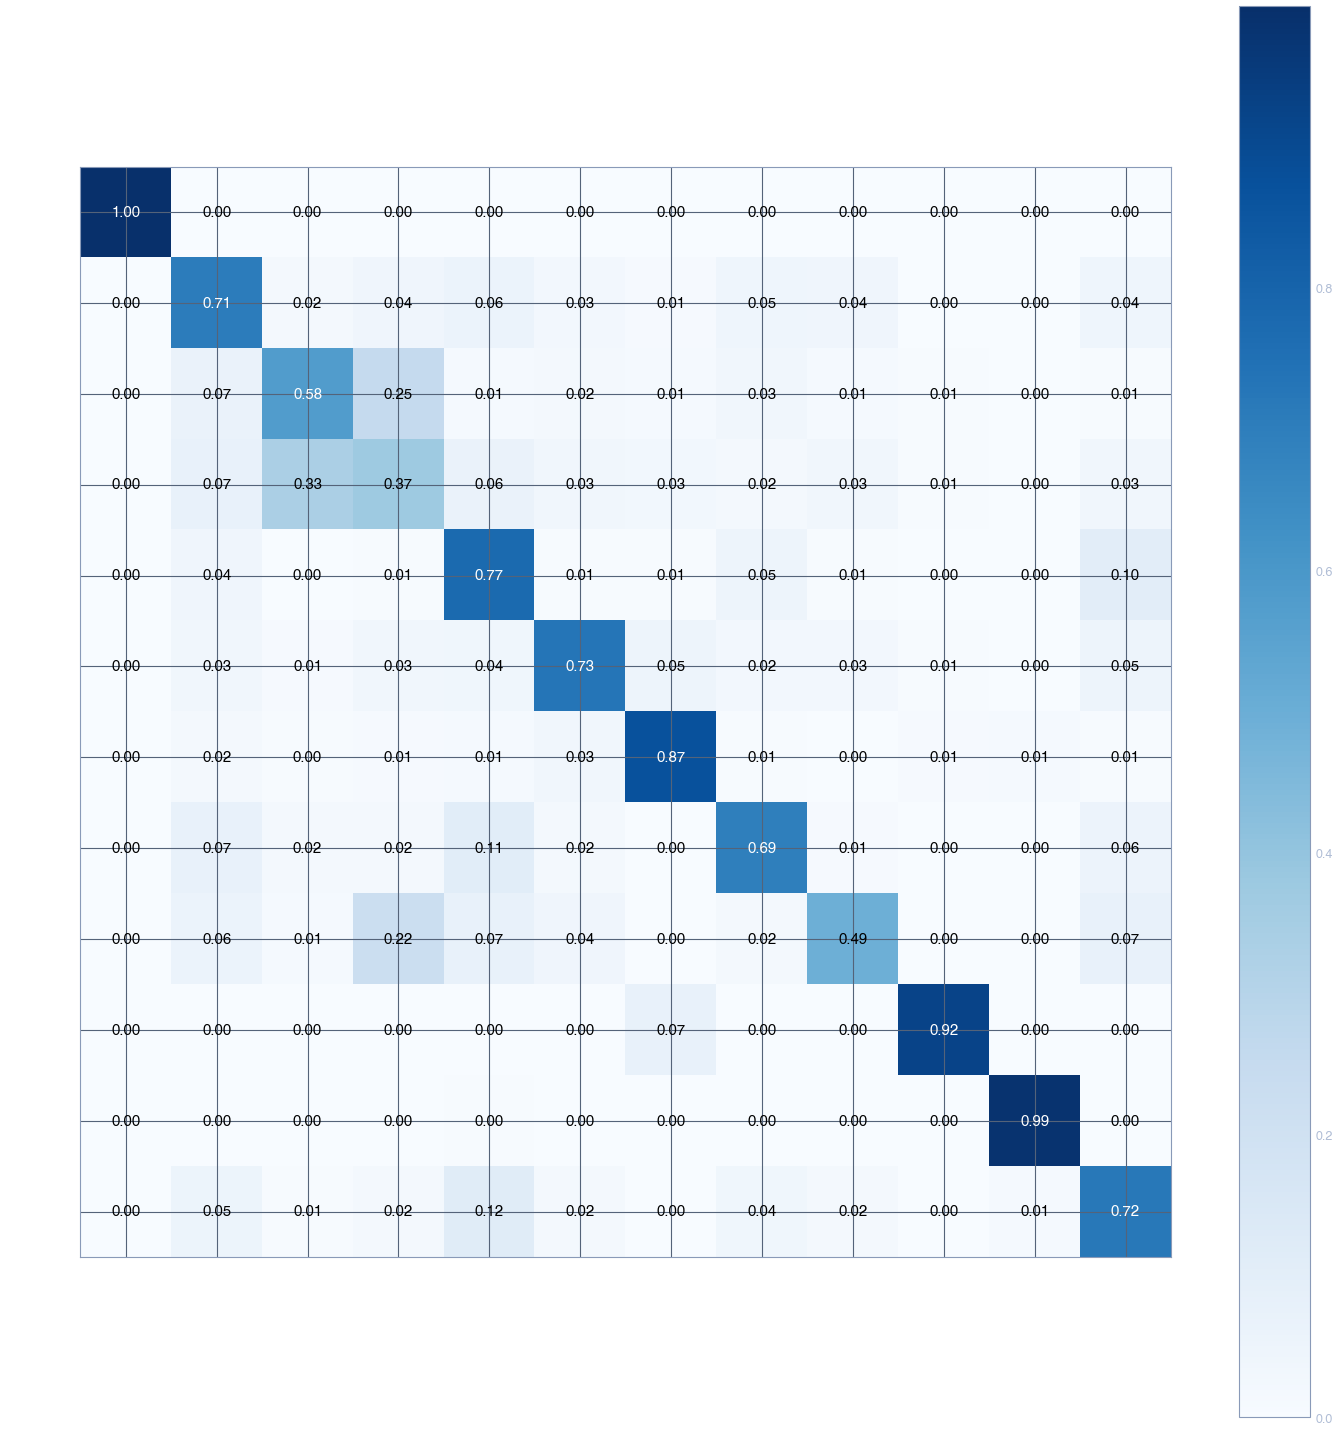

In [93]:
cm_xgb_bal_multi = confusion_matrix(bal_multi_y_test, bal_multi_xgb_preds)
classes = balanced_df['Label'].unique()
plot_confusion_matrix(cm_xgb_bal_multi, classes, normalize=True,
                      title='XGBoost Confusion Matrix', cmap=plt.cm.Blues)

plt.savefig('Images/bal_multi_xgb_conf_matrix.png', dpi = 100)

# Anomaly Detection Dataset

## Binary Classification (Anomaly Detection)

### Train Test Split

In [90]:
anom_binary_X = anomaly_df.drop(['Flow_ID', 'Label', 'HOPOPT', 'Malicious'], axis=1)
anom_binary_y = anomaly_df['Malicious']

anom_binary_X_train, anom_binary_X_test, anom_binary_y_train, anom_binary_y_test = train_test_split(
    anom_binary_X, anom_binary_y, stratify=anom_binary_y, test_size=0.25, random_state=0)

# Convert to list to avoid type error
anom_binary_y_train = list(anom_binary_y_train)
anom_binary_y_test = list(anom_binary_y_test)

### Standard Scalar

In [98]:
std_scaler = StandardScaler()

anom_binary_X_train_scl = std_scaler.fit_transform(anom_binary_X_train)
anom_binary_X_test_scl = std_scaler.transform(anom_binary_X_test)

### Dummy Classifier

In [99]:
anom_binary_dummy = DummyClassifier(random_state=0)
anom_binary_dummy.fit(anom_binary_X_train_scl, anom_binary_y_train)
anom_binary_dummy_preds = list(anom_binary_dummy.predict(anom_binary_X_test_scl))

/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


In [104]:
anom_binary_dummy_acc = accuracy_score(anom_binary_y_test, anom_binary_dummy_preds)
anom_binary_dummy_f1 = f1_score(anom_binary_y_test, anom_binary_dummy_preds)

print('Accuracy:', anom_binary_dummy_acc)
print('      F1:', anom_binary_dummy_f1)

Accuracy: 0.9777091491113331
      F1: 0.009102730819245775


### Gaussian Naive Bayes 

In [105]:
anom_binary_gnb = GaussianNB()
anom_binary_gnb.fit(anom_binary_X_train_scl, anom_binary_y_train)
anom_binary_gnb_preds = list(anom_binary_gnb.predict(anom_binary_X_test_scl))

In [106]:
anom_binary_gnb_acc = accuracy_score(anom_binary_y_test, anom_binary_gnb_preds)
anom_binary_gnb_f1 = f1_score(anom_binary_y_test, anom_binary_gnb_preds)

print('Accuracy:', anom_binary_gnb_acc)
print('      F1:', anom_binary_gnb_f1)

Accuracy: 0.6333334726337388
      F1: 0.055197811901018676


### Decision Tree

In [108]:
anom_binary_dt = DecisionTreeClassifier(random_state=0)
anom_binary_dt.fit(anom_binary_X_train_scl, anom_binary_y_train)
anom_binary_dt_preds = list(anom_binary_dt.predict(anom_binary_X_test_scl))

In [109]:
anom_binary_dt_acc = accuracy_score(anom_binary_y_test, anom_binary_dt_preds)
anom_binary_dt_f1 = f1_score(anom_binary_y_test, anom_binary_dt_preds)

print('Accuracy:', anom_binary_dt_acc)
print('      F1:', anom_binary_dt_f1)

Accuracy: 0.9998579135863864
      F1: 0.9936802973977695


### K Nearest Neighbors

In [ ]:
anom_binary_knn = KNeighborsClassifier()
anom_binary_knn.fit(anom_binary_X_train_scl, anom_binary_y_train)
anom_binary_knn_preds = list(anom_binary_knn.predict(anom_binary_X_test_scl))

In [ ]:
anom_binary_knn_acc = accuracy_score(anom_binary_y_test, anom_binary_knn_preds)
anom_binary_knn_f1 = f1_score(anom_binary_y_test, anom_binary_knn_preds)

print('Accuracy:', anom_binary_knn_acc)
print('      F1:', anom_binary_knn_f1)

### Random Forest

In [54]:
anom_binary_rf = RandomForestClassifier(random_state=0, n_jobs=-1)
anom_binary_rf.fit(anom_binary_X_train_scl, anom_binary_y_train)
anom_binary_rf_preds = list(anom_binary_rf.predict(anom_binary_X_test_scl))

In [55]:
anom_binary_rf_acc = accuracy_score(anom_binary_y_test, anom_binary_rf_preds)
anom_binary_rf_f1 = f1_score(anom_binary_y_test, anom_binary_rf_preds)

print('Accuracy:', anom_binary_rf_acc)
print('      F1:', anom_binary_rf_f1)

Accuracy: 0.9988847583643122
      F1: 0.9988954344624447


### XGBoost

In [56]:
anom_binary_xgb = XGBClassifier(random_state=0, n_jobs=-1)
anom_binary_xgb.fit(anom_binary_X_train_scl, anom_binary_y_train)
anom_binary_xgb_preds = list(anom_binary_xgb.predict(anom_binary_X_test_scl))

In [57]:
anom_binary_xgb_acc = accuracy_score(anom_binary_y_test, anom_binary_xgb_preds)
anom_binary_xgb_f1 = f1_score(anom_binary_y_test, anom_binary_xgb_preds)

print('Accuracy:', anom_binary_xgb_acc)
print('      F1:', anom_binary_xgb_f1)

Accuracy: 0.9994423791821562
      F1: 0.9994477172312224


### Feature Importances

Decision Tree

In [58]:
anom_binary_dt_features = dict(zip(anom_binary_X.columns, anom_binary_dt.feature_importances_))
anom_binary_dt_features = sorted(anom_binary_dt_features.items(), key=lambda x: x[1], reverse=True)
anom_binary_dt_features[:10]

[('Bwd_Pkt_Length_Max', 0.4321718724387804),
 ('Fwd_IAT_Min', 0.09638106984906894),
 ('ACK_Flag_Count', 0.09033950805271436),
 ('Bwd_Pkts_Sec', 0.04781227881326841),
 ('Pkt_Size_Mean', 0.047542461074881436),
 ('Fwd_Pkt_Length_Std', 0.047491182791384416),
 ('Fwd_Init_Win_Bytes', 0.041885485142335525),
 ('Bwd_Header_Length', 0.03417186684692964),
 ('Bwd_Init_Win_Bytes', 0.029978998366472578),
 ('URG_Flag_Count', 0.028887571059214186)]

Random Forest

In [59]:
anom_binary_rf_features = dict(zip(anom_binary_X.columns, anom_binary_rf.feature_importances_))
anom_binary_rf_features = sorted(anom_binary_rf_features.items(), key=lambda x: x[1], reverse=True)
anom_binary_rf_features[:10]

[('Bwd_Segment_Size_Mean', 0.06479943731326662),
 ('Bwd_Pkt_Length_Max', 0.05768429926659383),
 ('Fwd_Init_Win_Bytes', 0.051959549429500464),
 ('Bwd_Pkt_Length_Mean', 0.051723724983398243),
 ('Pkt_Length_Var', 0.05011734358632702),
 ('Pkt_Length_Min', 0.03474782546490374),
 ('Bwd_Subflow_Bytes', 0.03389031994987526),
 ('Fwd_Pkt_Length_Min', 0.031065625410276246),
 ('Bwd_Total_Bytes', 0.02808381988258205),
 ('Pkt_Length_Std', 0.026423405011124897)]

XGBoost

In [60]:
anom_binary_xgb_features = dict(zip(anom_binary_X.columns, anom_binary_xgb.feature_importances_))
anom_binary_xgb_features = sorted(anom_binary_xgb_features.items(), key=lambda x: x[1], reverse=True)
anom_binary_xgb_features[:10]

[('Bwd_Pkt_Length_Max', 0.7066348),
 ('Bwd_Pkt_Length_Mean', 0.046133853),
 ('Fwd_Pkt_Length_Std', 0.02572131),
 ('ACK_Flag_Count', 0.023738889),
 ('Bwd_Pkts_Sec', 0.018046636),
 ('Bwd_Header_Length', 0.01647789),
 ('PSH_Flag_Count', 0.015690256),
 ('Fwd_IAT_Min', 0.015220775),
 ('Fwd_Total_Pkts', 0.015060951),
 ('Pkt_Size_Mean', 0.011617822)]

## Multiclass Classification (Anomaly Detection)

### Train Test Split

In [65]:
anom_multi_X = anomaly_df.drop(['Flow_ID', 'Label', 'HOPOPT', 'Malicious'], axis=1)
anom_multi_y = anomaly_df['Label']

anom_multi_X_train, anom_multi_X_test, anom_multi_y_train, anom_multi_y_test = train_test_split(
    anom_multi_X, anom_multi_y, stratify=anom_multi_y, test_size=0.25, random_state=0)

# Convert to list to avoid type error
anom_multi_y_train = list(anom_multi_y_train)
anom_multi_y_test = list(anom_multi_y_test)

### Standard Scalar

In [66]:
std_scaler = StandardScaler()

anom_multi_X_train_scl = std_scaler.fit_transform(anom_multi_X_train)
anom_multi_X_test_scl = std_scaler.transform(anom_multi_X_test)

### Dummy Classifier

In [73]:
anom_multi_dummy = DummyClassifier(random_state=0)
anom_multi_dummy.fit(anom_multi_X_train_scl, anom_multi_y_train)
anom_multi_dummy_preds = list(anom_multi_dummy.predict(anom_multi_X_test_scl))

/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


In [74]:
anom_multi_dummy_acc = accuracy_score(anom_multi_y_test, anom_multi_dummy_preds)
anom_multi_dummy_f1 = f1_score(anom_multi_y_test, anom_multi_dummy_preds, average='weighted')

print('Accuracy:', anom_multi_dummy_acc)
print('      F1:', anom_multi_dummy_f1)

Accuracy: 0.2776951672862453
      F1: 0.27377289188976395


### Gaussian Naive Bayes

In [69]:
anom_multi_gnb = GaussianNB()
anom_multi_gnb.fit(anom_multi_X_train_scl, anom_multi_y_train)
anom_multi_gnb_preds = list(anom_multi_gnb.predict(anom_multi_X_test_scl))

In [70]:
anom_multi_gnb_acc = accuracy_score(anom_multi_y_test, anom_multi_gnb_preds)
anom_multi_gnb_f1 = f1_score(anom_multi_y_test, anom_multi_gnb_preds, average='weighted')

print('Accuracy:', anom_multi_gnb_acc)
print('      F1:', anom_multi_gnb_f1)

Accuracy: 0.3140334572490706
      F1: 0.3481777387956166


### Decision Tree

In [71]:
anom_multi_dt = DecisionTreeClassifier(random_state=0)
anom_multi_dt.fit(anom_multi_X_train_scl, anom_multi_y_train)
anom_multi_dt_preds = list(anom_multi_dt.predict(anom_multi_X_test_scl))

In [72]:
anom_multi_dt_acc = accuracy_score(anom_multi_y_test, anom_multi_dt_preds)
anom_multi_dt_f1 = f1_score(anom_multi_y_test, anom_multi_dt_preds, average='weighted')

print('Accuracy:', anom_multi_dt_acc)
print('      F1:', anom_multi_dt_f1)

Accuracy: 0.8467472118959107
      F1: 0.8472017627615264


### K Nearest Neighbors

In [75]:
anom_multi_knn = KNeighborsClassifier()
anom_multi_knn.fit(anom_multi_X_train_scl, anom_multi_y_train)
anom_multi_knn_preds = list(anom_multi_knn.predict(anom_multi_X_test_scl))

In [76]:
anom_multi_knn_acc = accuracy_score(anom_multi_y_test, anom_multi_knn_preds)
anom_multi_knn_f1 = f1_score(anom_multi_y_test, anom_multi_knn_preds, average='weighted')

print('Accuracy:', anom_multi_knn_acc)
print('      F1:', anom_multi_knn_f1)

Accuracy: 0.8433085501858736
      F1: 0.8396681128702419


### Random Forest

In [77]:
anom_multi_rf = RandomForestClassifier(random_state=0, n_jobs=-1)
anom_multi_rf.fit(anom_multi_X_train_scl, anom_multi_y_train)
anom_multi_rf_preds = list(anom_multi_rf.predict(anom_multi_X_test_scl))

In [80]:
anom_multi_rf_acc = accuracy_score(anom_multi_y_test, anom_multi_rf_preds)
anom_multi_rf_f1 = f1_score(anom_multi_y_test, anom_multi_rf_preds, average='weighted')

print('Accuracy:', anom_multi_rf_acc)
print('      F1:', anom_multi_rf_f1)

Accuracy: 0.8523234200743495
      F1: 0.8519008118496785


### XGBoost

In [81]:
anom_multi_xgb = XGBClassifier(random_state=0, n_jobs=-1)
anom_multi_xgb.fit(anom_multi_X_train_scl, anom_multi_y_train)
anom_multi_xgb_preds = list(anom_multi_xgb.predict(anom_multi_X_test_scl))

In [82]:
anom_multi_xgb_acc = accuracy_score(anom_multi_y_test, anom_multi_xgb_preds)
anom_multi_xgb_f1 = f1_score(anom_multi_y_test, anom_multi_xgb_preds, average='weighted')

print('Accuracy:', anom_multi_xgb_acc)
print('      F1:', anom_multi_xgb_f1)

Accuracy: 0.8650557620817844
      F1: 0.8647730500675536


### Feature Importances

Decision Tree

In [83]:
anom_multi_dt_features = dict(zip(anom_multi_X.columns, anom_multi_dt.feature_importances_))
anom_multi_dt_features = sorted(anom_multi_dt_features.items(), key=lambda x: x[1], reverse=True)
anom_multi_dt_features[:10]

[('Bwd_Pkt_Length_Max', 0.17813608910486856),
 ('Pkt_Length_Min', 0.13232021964005997),
 ('Fwd_Init_Win_Bytes', 0.07129227402814149),
 ('Flow_Bytes_Sec', 0.05254508982369269),
 ('ACK_Flag_Count', 0.04822122872673132),
 ('Fwd_IAT_Min', 0.048125155685704676),
 ('Flow_IAT_Max', 0.04057134077946873),
 ('Bwd_Pkts_Sec', 0.02851069734541092),
 ('Fwd_Subflow_Bytes', 0.027439768028378247),
 ('Bwd_Header_Length', 0.027045377146699245)]

Random Forest

In [84]:
anom_multi_rf_features = dict(zip(anom_multi_X.columns, anom_multi_rf.feature_importances_))
anom_multi_rf_features = sorted(anom_multi_rf_features.items(), key=lambda x: x[1], reverse=True)
anom_multi_rf_features[:10]

[('Fwd_Init_Win_Bytes', 0.052314072135577656),
 ('Pkt_Size_Mean', 0.033927197406239375),
 ('Pkt_Length_Min', 0.03362226368219828),
 ('Flow_IAT_Mean', 0.03229548261837191),
 ('Fwd_Pkt_Length_Min', 0.02929883891176453),
 ('Fwd_Segment_Size_Mean', 0.029189954369181214),
 ('Pkt_Length_Mean', 0.02841634731314821),
 ('Bwd_Segment_Size_Mean', 0.027442983138788266),
 ('Fwd_Pkts_Sec', 0.02733519211706754),
 ('Flow_IAT_Max', 0.02732665349636803)]

XGBoost

In [85]:
anom_multi_xgb_features = dict(zip(anom_multi_X.columns, anom_multi_xgb.feature_importances_))
anom_multi_xgb_features = sorted(anom_multi_xgb_features.items(), key=lambda x: x[1], reverse=True)
anom_multi_xgb_features[:10]

[('Bwd_Pkt_Length_Max', 0.8722749),
 ('Pkt_Length_Min', 0.014750869),
 ('ACK_Flag_Count', 0.01015347),
 ('CWE_Flag_Count', 0.008745772),
 ('Time_Idle_Std', 0.0071296976),
 ('PSH_Flag_Count', 0.005871469),
 ('Bwd_Header_Length', 0.0050045243),
 ('Fwd_Total_Bytes', 0.0049487054),
 ('UDP', 0.004383982),
 ('URG_Flag_Count', 0.0042051356)]

## Confusion Matrix

Normalized confusion matrix
[[9.99624765e-01 0.00000000e+00 1.87617261e-04 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.87617261e-04 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.70648464e-03 7.06484642e-01 2.21843003e-02 3.92491468e-02
  6.14334471e-02 2.73037543e-02 8.53242321e-03 4.60750853e-02
  4.09556314e-02 0.00000000e+00 1.70648464e-03 4.43686007e-02]
 [0.00000000e+00 6.50000000e-02 5.77500000e-01 2.50000000e-01
  1.25000000e-02 2.00000000e-02 1.50000000e-02 3.25000000e-02
  1.50000000e-02 5.00000000e-03 0.00000000e+00 7.50000000e-03]
 [0.00000000e+00 7.21649485e-02 3.32474227e-01 3.73711340e-01
  6.44329897e-02 3.35051546e-02 2.83505155e-02 2.31958763e-02
  3.35051546e-02 5.15463918e-03 0.00000000e+00 3.35051546e-02]
 [1.82481752e-03 4.19708029e-02 3.64963504e-03 7.29927007e-03
  7.73722628e-01 5.47445255e-03 5.47445255e-03 4.74452555e-02
  7.29927007e-03 0.00000000e+00 3.64963504e-03 1.02189781e-01]
 [0.00000000e+00 3.20641283e-02 1.002

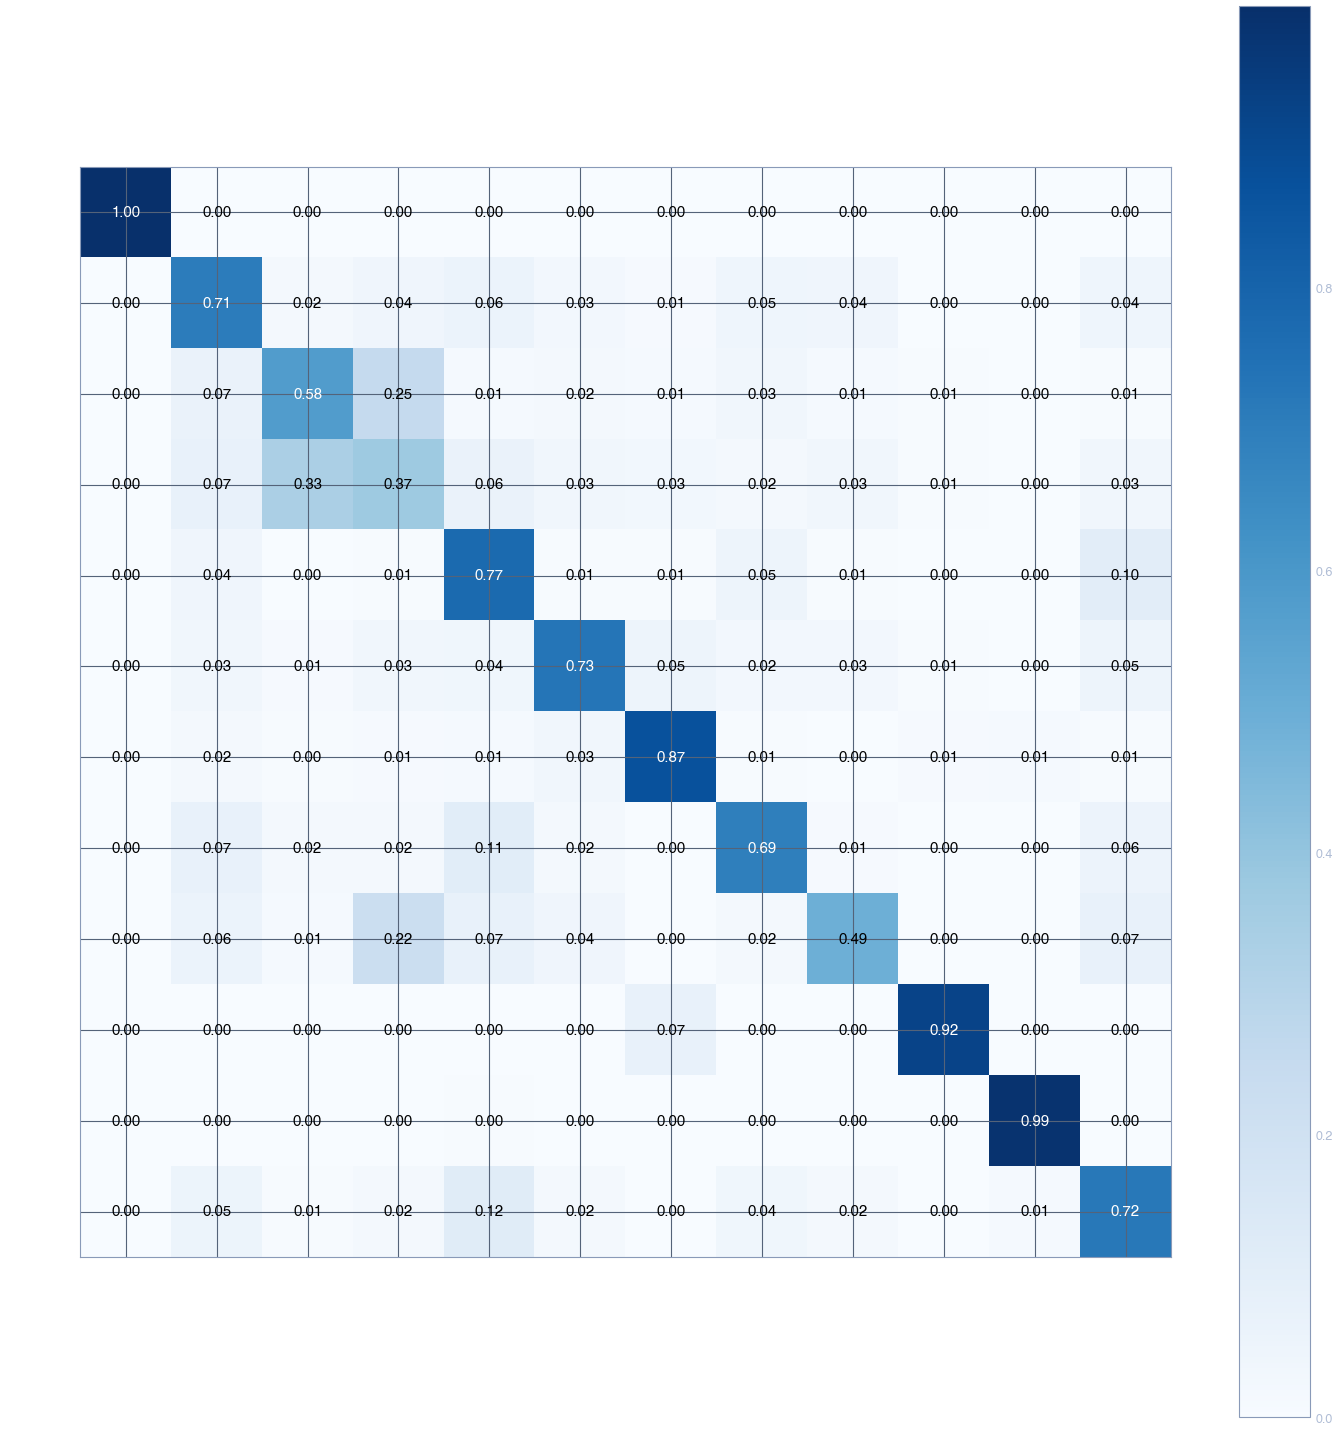

In [93]:
cm_xgb_anom_multi = confusion_matrix(anom_multi_y_test, anom_multi_xgb_preds)
classes = anomaly_df['Label'].unique()
plot_confusion_matrix(cm_xgb_anom_multi, classes, normalize=True,
                      title='XGBoost Confusion Matrix', cmap=plt.cm.Blues)

# plt.savefig('Images/bal_multi_xgb_conf_matrix.png', dpi = 100)

# Export Model Results

Scores

In [99]:
model_scores = pd.DataFrame({
    'Score':['Accuracy', 'F1_Score'],
    'Bal_Binary_Dummy':[bal_binary_dummy_acc, bal_binary_dummy_f1],
    'Bal_Binary_GNB':[bal_binary_gnb_acc, bal_binary_gnb_f1],
    'Bal_Binary_DT':[bal_binary_dt_acc, bal_binary_dt_f1],
    'Bal_Binary_KNN':[bal_binary_knn_acc, bal_binary_knn_f1],
    'Bal_Binary_RF':[bal_binary_rf_acc, bal_binary_rf_f1],
    'Bal_Binary_XGB':[bal_binary_xgb_acc, bal_binary_xgb_f1],
    'Bal_Multicalss_Dummy':[bal_multi_dummy_acc, bal_multi_dummy_f1],
    'Bal_Multiclass_GNB':[bal_multi_gnb_acc, bal_binary_gnb_f1],
    'Bal_Multiclass_DT':[bal_multi_dt_acc, bal_multi_dt_f1],
    'Bal_Multiclass_KNN':[bal_multi_knn_acc, bal_multi_knn_f1],
    'Bal_Multiclass_RF':[bal_multi_rf_acc, bal_multi_rf_f1],
    'Bal_Multiclass_XGB':[bal_multi_xgb_acc, bal_multi_xgb_f1]
})

model_scores

,Score,Bal_Binary_Dummy,Bal_Binary_GNB,Bal_Binary_DT,Bal_Binary_KNN,Bal_Binary_RF,Bal_Binary_XGB,Bal_Multicalss_Dummy,Bal_Multiclass_GNB,Bal_Multiclass_DT,Bal_Multiclass_KNN,Bal_Multiclass_RF,Bal_Multiclass_XGB
0,Accuracy,0.503996,0.694331,0.997955,0.996004,0.998885,0.999442,0.277695,0.314033,0.846747,0.843309,0.852323,0.865056
1,F1_Score,0.501075,0.749600,0.997975,0.996042,0.998895,0.999448,0.273773,0.749600,0.847202,0.839668,0.851901,0.864773


In [103]:
# model_scores.to_csv('Model_Results/Model_Scores.csv')

Feature importances

In [101]:
features = []
for i in range(1, len(bal_binary_dt_features)+1):
    features.append(f'Feature_{i}')

In [102]:
feature_importances = pd.DataFrame({
    'Feature':features,
    'Bal_Binary_DT':bal_binary_dt_features,
    'Bal_Binary_RF':bal_binary_rf_features,
    'Bal_Binary_XGB':bal_binary_xgb_features,
    'Bal_Multiclass_DT':bal_multi_dt_features,
    'Bal_Multiclass_RF':bal_multi_rf_features,
    'Bal_Multiclass_XGB':bal_multi_xgb_features
})

feature_importances.head()

,Feature,Bal_Binary_DT,Bal_Binary_RF,Bal_Binary_XGB,Bal_Multiclass_DT,Bal_Multiclass_RF,Bal_Multiclass_XGB
0,Feature_1,"(Bwd_Pkt_Length_Max, 0.4321718724387804)","(Bwd_Segment_Size_Mean, 0.06479943731326662)","(Bwd_Pkt_Length_Max, 0.7066348)","(Bwd_Pkt_Length_Max, 0.17813608910486856)","(Fwd_Init_Win_Bytes, 0.052314072135577656)","(Bwd_Pkt_Length_Max, 0.8722749)"
1,Feature_2,"(Fwd_IAT_Min, 0.09638106984906894)","(Bwd_Pkt_Length_Max, 0.05768429926659383)","(Bwd_Pkt_Length_Mean, 0.046133853)","(Pkt_Length_Min, 0.13232021964005997)","(Pkt_Size_Mean, 0.033927197406239375)","(Pkt_Length_Min, 0.014750869)"
2,Feature_3,"(ACK_Flag_Count, 0.09033950805271436)","(Fwd_Init_Win_Bytes, 0.051959549429500464)","(Fwd_Pkt_Length_Std, 0.02572131)","(Fwd_Init_Win_Bytes, 0.07129227402814149)","(Pkt_Length_Min, 0.03362226368219828)","(ACK_Flag_Count, 0.01015347)"
3,Feature_4,"(Bwd_Pkts_Sec, 0.04781227881326841)","(Bwd_Pkt_Length_Mean, 0.051723724983398243)","(ACK_Flag_Count, 0.023738889)","(Flow_Bytes_Sec, 0.05254508982369269)","(Flow_IAT_Mean, 0.03229548261837191)","(CWE_Flag_Count, 0.008745772)"
4,Feature_5,"(Pkt_Size_Mean, 0.047542461074881436)","(Pkt_Length_Var, 0.05011734358632702)","(Bwd_Pkts_Sec, 0.018046636)","(ACK_Flag_Count, 0.04822122872673132)","(Fwd_Pkt_Length_Min, 0.02929883891176453)","(Time_Idle_Std, 0.0071296976)"


In [104]:
# feature_importances.to_csv('Model_Results/Feature_Importances.csv')